### Import Libraries

In [3]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

from bs4 import BeautifulSoup 
import urllib3
import certifi

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library



# Lookup Address
import geocoder
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="coursera_capstone")

# import k-means for clustering stage
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 


print('Libraries imported.')

Libraries imported.


### Set Work Location

In [4]:
work_address = '29 Oxford St, Cambridge, MA 02138'
work_name = 'Harvard Biology'

geolocator = Nominatim(user_agent="coursera_capstone")
location = geolocator.geocode(work_address)
w_latitude = location.latitude
w_longitude = location.longitude
print('The geograpical coordinate of your work location are {}, {}.'.format(w_latitude, w_longitude))

The geograpical coordinate of your work location are 42.3780016, -71.1170381.


In [5]:
df = pd.DataFrame(columns=["Work", "Latitude", "Longitude"], data=[[work_name,w_latitude, w_longitude]])
df.head()

,Work,Latitude,Longitude
0,Harvard Biology,42.378002,-71.117038


### Map Work Location

In [6]:
# create map of New York using latitude and longitude values
map_boston = folium.Map(location=[w_latitude, w_longitude], zoom_start=15)

# add markers to map
for lat, lng, Work in zip(df['Latitude'], df['Longitude'], df['Work']):
    label = '{}'.format(Work)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

### Pull in Venues that are within 4 kilometers of work location

In [7]:
#Foursquare
CLIENT_ID = 'CATSTTUMLUMROE0H5N0XHZFGOP3R2Q1QHDCV5XZC0VPNHMEE' # your Foursquare ID
CLIENT_SECRET = 'KUHXV2XFQXLM0BV5DDCKVTBZZBYNBRWN3AQM25I0DGQ5PVBX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CATSTTUMLUMROE0H5N0XHZFGOP3R2Q1QHDCV5XZC0VPNHMEE
CLIENT_SECRET:KUHXV2XFQXLM0BV5DDCKVTBZZBYNBRWN3AQM25I0DGQ5PVBX


In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=4000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
venues =  getNearbyVenues(names=df['Work'], latitudes=df['Latitude'], longitudes=df['Longitude'])

Harvard Biology


### Visualize the venues on a map

In [10]:
dfv = venues
dfv.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harvard Biology,42.378002,-71.117038,Harvard Museum of Natural History,42.378410,-71.115720,Science Museum
1,Harvard Biology,42.378002,-71.117038,Peabody Museum of Archaeology and Ethnology,42.378146,-71.114734,History Museum
2,Harvard Biology,42.378002,-71.117038,Sanders Theatre,42.375835,-71.114786,Theater
3,Harvard Biology,42.378002,-71.117038,Harvard Art Museums,42.374206,-71.114368,Art Museum
4,Harvard Biology,42.378002,-71.117038,Harvard Square,42.373501,-71.119098,Plaza


In [11]:
dfv.shape

(100, 7)

In [12]:
# create map of New York using latitude and longitude values
map_boston_venues = folium.Map(location=[w_latitude, w_longitude], zoom_start=15)

# add markers to map
for lat, lng, venue, venue_category in zip(dfv['Venue Latitude'], dfv['Venue Longitude'], dfv['Venue'], dfv['Venue Category']):
    label = '{}, {}'.format(venue, venue_category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston_venues)  
    
map_boston_venues

### Cluster the venuess into geolocated "neighborhoods"

#### First find the correct number of clusters - using elbow method

In [13]:
X = dfv[['Venue Latitude', 'Venue Longitude']].values

In [14]:
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

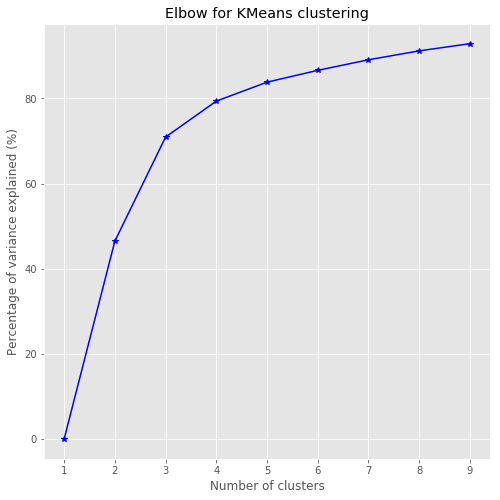

In [15]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)


#### Generate cluster numbers

In [16]:
# set number of clusters
kclusters = 4

dfv_c = dfv[['Venue Latitude', 'Venue Longitude']].values

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfv_c)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

#### Add cluster numbers to venue data

In [17]:
dfv_m = dfv

# add clustering labels
dfv_m['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#dfv_m = dfv_m.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dfv_m.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,Harvard Biology,42.378002,-71.117038,Harvard Museum of Natural History,42.378410,-71.115720,Science Museum,2
1,Harvard Biology,42.378002,-71.117038,Peabody Museum of Archaeology and Ethnology,42.378146,-71.114734,History Museum,2
2,Harvard Biology,42.378002,-71.117038,Sanders Theatre,42.375835,-71.114786,Theater,2
3,Harvard Biology,42.378002,-71.117038,Harvard Art Museums,42.374206,-71.114368,Art Museum,2
4,Harvard Biology,42.378002,-71.117038,Harvard Square,42.373501,-71.119098,Plaza,2


### Visualize the Clusters

In [32]:
# create map
map_clusters = folium.Map(location=[w_latitude, w_longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfv['Venue Latitude'], dfv['Venue Longitude'], dfv['Venue'], dfv['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

### Examine the Neighbohoods

In [19]:
# one hot encoding
df_oh = pd.get_dummies(dfv[['Venue Category']], prefix="", prefix_sep="")

In [29]:
# add Cluster column back to dataframe
df_oh['Cluster Labels'] = dfv['Cluster Labels'] 

In [30]:
# move neighborhood column to the first column
df_oh.set_index('Cluster Labels', inplace=True)
df_oh.reset_index(inplace=True)

In [31]:
#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

df_g = df_oh.groupby('Cluster Labels').mean().reset_index()

#### Putting into a *pandas* dataframe
function to sort the venues in descending order.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Top 10 venues for each neighborhood.

In [25]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

In [26]:
# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_s = pd.DataFrame(columns=columns)
df_s['Cluster Labels'] = df_g['Cluster Labels']

for ind in np.arange(df_g.shape[0]):
    df_s.iloc[ind, 1:] = return_most_common_venues(df_g.iloc[ind, :], num_top_venues)

df_s

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Cocktail Bar,Yoga Studio,Sandwich Place,Ethiopian Restaurant,Dumpling Restaurant,New American Restaurant,Comedy Club,Coffee Shop,Restaurant,Brewery
1,1,Bakery,Café,Japanese Restaurant,Wine Bar,Organic Grocery,Park,Pizza Place,Mexican Restaurant,Pub,Market
2,2,Café,Pizza Place,Mexican Restaurant,Theater,Bookstore,American Restaurant,Nightclub,New American Restaurant,Music Venue,Jazz Club
3,3,Tapas Restaurant,New American Restaurant,Coffee Shop,Brewery,Café,Portuguese Restaurant,Pub,General Entertainment,Mediterranean Restaurant,Donut Shop


## Results
You can now see what the most common type of venue is in each cluster "Neighborhood".  You can see the location of the neighborhood on the map, and you can see just how many venues are in each Neighborhood.  This should help you make the decision on where you want to live.